# 약물-단백질 상호작용

## 단백질 특성 표현법
- 단백질은 여러 아미노산의 다양한 조합으로 구성된다
- 아미노산은 20개의 표준 아미노산과 이외의 희귀 아미노산으로 분류된다
- 머신러닝 모델의 입력으로 사용할 단백질 데이터는 아미노산을 알파셋으로 표현한 배열로 사용한다

In [ ]:
!pip install pandas-flavor
!pip install git+https://github.com/bp-kelley/descriptastorus
!pip install DeepPurpose


[notice] A new release of pip is available: 23.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Cloning https://github.com/bp-kelley/descriptastorus to c:\users\tonyw\appdata\local\temp\pip-req-build-mngdqb61
  Resolved https://github.com/bp-kelley/descriptastorus to commit 86eedc60546abe6f59cdbcb12025a61157ba178d
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/bp-kelley/descriptastorus 'C:\Users\tonyw\AppData\Local\Temp\pip-req-build-mngdqb61'

[notice] A new release of pip is available: 23.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import torch
import DeepPurpose.DTI as models
from DeepPurpose.utils import *
from DeepPurpose.dataset import *
import DeepPurpose.oneliner as oneliner
import numpy as np

In [2]:

target, target_name = load_SARS_CoV_Protease_3CL()
X_drug, X_target, y = load_AID1706_SARS_CoV_3CL('./data', seed = 1234)
X_repurpose, drug_names, drug_CID = load_antiviral_drugs('./data')

Beginning Processing...
100% [....................................................] 39480319 / 39480319

/home/dilab162/anaconda3/lib/python3.9/site-packages/DeepPurpose/dataset.py:364: DtypeWarning: Columns (0,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_data = pd.read_csv(saved_path_data)
/home/dilab162/anaconda3/lib/python3.9/site-packages/DeepPurpose/dataset.py:369: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['binary_label'][(val.PUBCHEM_ACTIVITY_SCORE >= threshold) & (val.PUBCHEM_ACTIVITY_SCORE <=100)] = 1


Default binary threshold for the binding affinity scores is 15, recommended by the investigator
Done!


In [8]:
# X_drug, X_target, y = load_process_DAVIS('./data/', binary=False)

drug_encoding = 'CNN'
target_encoding = 'CNN'
train, val, test = data_process(X_drug, X_target, y, 
                                drug_encoding, target_encoding, 
                                split_method='random',frac=[0.8,0.1,0.1])

Drug Target Interaction Prediction Mode...
in total: 26640 drug-target pairs
encoding drug...
unique drugs: 13764
encoding protein...
unique target sequence: 1
splitting dataset...
Done.


In [9]:
X_target

'SGFKKLVSPSSAVEKCIVSVSYRGNNLNGLWLGDSIYCPRHVLGKFSGDQWGDVLNLANNHEFEVVTQNGVTLNVVSRRLKGAVLILQTAVANAETPKYKFVKANCGDSFTIACSYGGTVIGLYPVTMRSNGTIRASFLAGACGSVGFNIEKGVVNFFYMHHLELPNALHTGTDLMGEFYGGYVDEEVAQRVPPDNLVTNNIVAWLYAAIISVKESSFSQPKWLESTTVSIEDYNRWASDNGFTPFSTSTAITKLSAITGVDVCKLLRTIMVKSAQWGSDPILGQYNFEDELTPESVFNQVGGVRLQ'

## 약물-단백질 상호작용(DTI) 이해

- 약물과 단백질의 상호작용 정도를 점수화한 데이터를 통해 학습하는 머신러닝 모델
- 약물과 단백질 데이터를 동시에 입력받아 상호작용 점수를 예측한다
- 동작은 아래와 같음
    1. 약물의 특성과 단백질(타겟)의 특성을 추출한다 (모델은 MLP, CNN, LSTM, Transformer 등 다양한 모델 사용가능)
    2. 추출된 특성을 이어붙여(concatenate) 예측 레이어에 입력한다
    3. 예측레이어를 통해 최종 상호작용 점수를 예측한다 (상호작용 여부를 분류하는 경우 0과 1로 이진분류, 상호작용 점수를 예측하는 경우 회귀)
![nn](image/DTI.png)

## 머신러닝을 이용한 DTI 예측 모델

### 데이터 확인

In [10]:
train

,SMILES,Target Sequence,Label,drug_encoding,target_encoding
0,CCOC1=CC=C(C=C1)C(=O)NC2=CC=CC=C2N3CCOCC3,SGFKKLVSPSSAVEKCIVSVSYRGNNLNGLWLGDSIYCPRHVLGKF...,0,"[C, C, O, C, 1, =, C, C, =, C, (, C, =, C, 1, ...","[S, G, F, K, K, L, V, S, P, S, S, A, V, E, K, ..."
1,CC1=CC=C(C=C1)C(=O)NC(=C(Cl)Cl)C#N,SGFKKLVSPSSAVEKCIVSVSYRGNNLNGLWLGDSIYCPRHVLGKF...,1,"[C, C, 1, =, C, C, =, C, (, C, =, C, 1, ), C, ...","[S, G, F, K, K, L, V, S, P, S, S, A, V, E, K, ..."
2,CC1=CC(=O)OC2=C1C=CC(=C2)NC(=O)C3=CC=CC=C3OC(F)F,SGFKKLVSPSSAVEKCIVSVSYRGNNLNGLWLGDSIYCPRHVLGKF...,1,"[C, C, 1, =, C, C, (, =, O, ), O, C, 2, =, C, ...","[S, G, F, K, K, L, V, S, P, S, S, A, V, E, K, ..."
3,CCN(CC)C(=O)CN1C=C(C2=CC=CC=C21)/C=C/3\C(=O)NC...,SGFKKLVSPSSAVEKCIVSVSYRGNNLNGLWLGDSIYCPRHVLGKF...,1,"[C, C, N, (, C, C, ), C, (, =, O, ), C, N, 1, ...","[S, G, F, K, K, L, V, S, P, S, S, A, V, E, K, ..."
4,C1=CC=C(C(=C1)/C=C/C(=O)C2=C(C=CC(=C2)Br)OC(=O...,SGFKKLVSPSSAVEKCIVSVSYRGNNLNGLWLGDSIYCPRHVLGKF...,1,"[C, 1, =, C, C, =, C, (, C, (, =, C, 1, ), ?, ...","[S, G, F, K, K, L, V, S, P, S, S, A, V, E, K, ..."
...,...,...,...,...,...
21307,C1CC(=O)N(C1=O)C2=C(C=CC(=C2)Cl)OC(=O)C3=CC=CO3,SGFKKLVSPSSAVEKCIVSVSYRGNNLNGLWLGDSIYCPRHVLGKF...,1,"[C, 1, C, C, (, =, O, ), N, (, C, 1, =, O, ), ...","[S, G, F, K, K, L, V, S, P, S, S, A, V, E, K, ..."
21308,CC(=O)NC1C2=C(C=CC(=C2)F)N(C1=O)CCN3CCOCC3.Cl,SGFKKLVSPSSAVEKCIVSVSYRGNNLNGLWLGDSIYCPRHVLGKF...,1,"[C, C, (, =, O, ), N, C, 1, C, 2, =, C, (, C, ...","[S, G, F, K, K, L, V, S, P, S, S, A, V, E, K, ..."
21309,COC1=CC=C(C=C1)C(=O)OC2=CN=CC=C2,SGFKKLVSPSSAVEKCIVSVSYRGNNLNGLWLGDSIYCPRHVLGKF...,1,"[C, O, C, 1, =, C, C, =, C, (, C, =, C, 1, ), ...","[S, G, F, K, K, L, V, S, P, S, S, A, V, E, K, ..."
21310,C1CCC(CC1)C2=NC3=CC=CC=C3C(=N2)SCC(=O)NCC4=CC5...,SGFKKLVSPSSAVEKCIVSVSYRGNNLNGLWLGDSIYCPRHVLGKF...,0,"[C, 1, C, C, C, (, C, C, 1, ), C, 2, =, N, C, ...","[S, G, F, K, K, L, V, S, P, S, S, A, V, E, K, ..."


In [11]:
num = 5
print('Drug 1: ' + X_drug[num])
print('Target 1: ' + X_target)
print('Score 1: ' + str(y[num]))

Drug 1: CCN(CC)C(=O)CN1C=C(C2=CC=CC=C21)/C=C/3\C(=O)NC(=O)N(C3=O)C4=CC=CC=C4F
Target 1: SGFKKLVSPSSAVEKCIVSVSYRGNNLNGLWLGDSIYCPRHVLGKFSGDQWGDVLNLANNHEFEVVTQNGVTLNVVSRRLKGAVLILQTAVANAETPKYKFVKANCGDSFTIACSYGGTVIGLYPVTMRSNGTIRASFLAGACGSVGFNIEKGVVNFFYMHHLELPNALHTGTDLMGEFYGGYVDEEVAQRVPPDNLVTNNIVAWLYAAIISVKESSFSQPKWLESTTVSIEDYNRWASDNGFTPFSTSTAITKLSAITGVDVCKLLRTIMVKSAQWGSDPILGQYNFEDELTPESVFNQVGGVRLQ
Score 1: 1


### 모델 정의 및 학습

In [13]:
config = generate_config(cuda_id = 0,
                         drug_encoding = drug_encoding, 
                         target_encoding = target_encoding, 
                         cls_hidden_dims = [512,128], 
                         train_epoch = 10, 
                         LR = 0.001, 
                         batch_size = 256,
                         cnn_drug_filters = [32,32],
                         cnn_target_filters = [32,32],
                         cnn_drug_kernels = [4,6],
                         cnn_target_kernels = [4,8]
                        )
model = models.model_initialize(**config)

Let's use 2 GPUs!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69125. Total time 0.005 hours
Validation at Epoch 1, AUROC: 0.81861 , AUPRC: 0.82356 , F1: 0.75205 , Cross-entropy Loss: 8.20693
Training at Epoch 2 iteration 0 with loss 0.51483. Total time 0.02166 hours
Validation at Epoch 2, AUROC: 0.89755 , AUPRC: 0.89659 , F1: 0.83722 , Cross-entropy Loss: 5.60095
Training at Epoch 3 iteration 0 with loss 0.31892. Total time 0.03833 hours
Validation at Epoch 3, AUROC: 0.95561 , AUPRC: 0.94512 , F1: 0.85714 , Cross-entropy Loss: 5.41948
Training at Epoch 4 iteration 0 with loss 0.31070. Total time 0.055 hours
Validation at Epoch 4, AUROC: 0.97920 , AUPRC: 0.96593 , F1: 0.95661 , Cross-entropy Loss: 1.51693
Training at Epoch 5 iteration 0 with loss 0.11116. Total time 0.07166 hours
Validation at Epoch 5, AUROC: 0.98275 , AUPRC: 0.97124 , F1: 0.87089 , Cross-entropy Loss: 5.04350
Training at Epoch 6 iteration 0 with loss 0.31849. Total time 

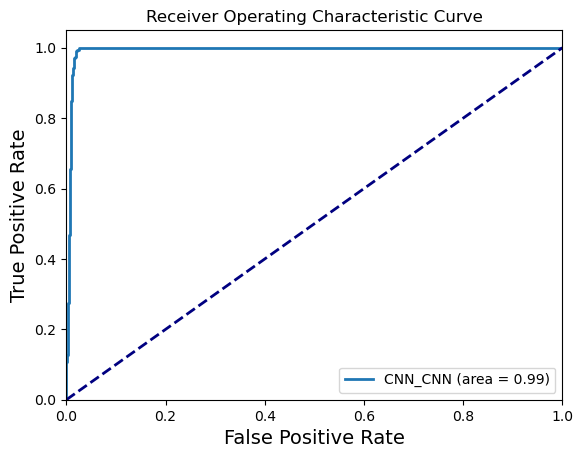

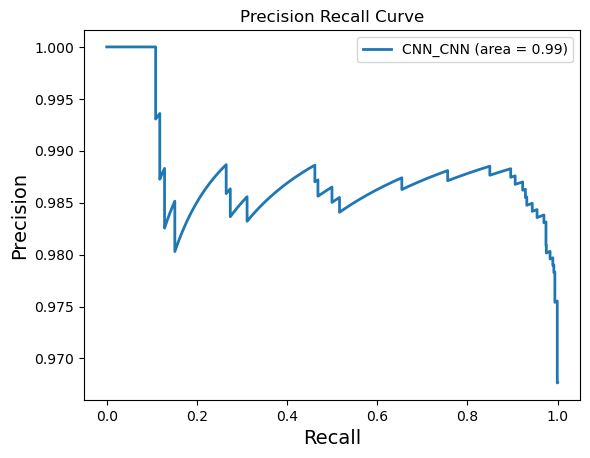

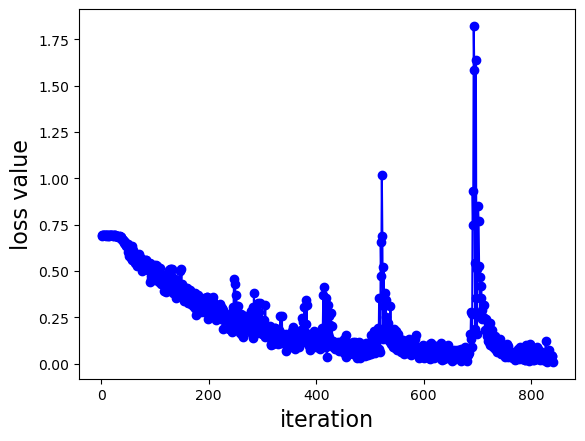

In [14]:
model.train(train, val, test)

In [17]:
def get_test_result():
    with open('./result/test_markdowntable.txt', 'r') as f:
        result = f.readlines()[-2].replace(' ', '').split('|')
        AUROC, AUPRC, F1 = result[1], result[2], result[3]
        return AUROC, AUPRC, F1

In [18]:
get_test_result()

('0.9932', '0.9876', '0.9839')